## Part 1: KNN

* *Warm up exercises: K-nearest-neighbors*

>*How does K-nearest-neighbors work? Explain in your own words.*

K-nearest-neighbors is a machine learning classification algorithm. It classifies each data point according to its nearest neighbors. K holds for the number of neighbors. Thus, if K=3 means that each point will be classified according to its 3 nearest neighbors.

>*Explain in your own words: What is the curse of dimensionality? Use figure 12-6 to as part of your explanation.*

<img  src="TYIT4EFGSA7D2PLAYVS0L3BDUVQSHS04.png"/>

The curse of dimensionality means that when the **dimensionality** increases, the **volume** of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance. In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality.

* *Exercise: K-nearest-neighbors map.*

>*The goal of this exercise is to create a useful real-world version of the example on pp153 in DSFS. We know from last week's exercises that the focus crimes PROSTITUTION, DRUG/NARCOTIC and DRIVING UNDER THE INFLUENCE tend to be concentrated in certain neighborhoods, so we focus on those crime types since they will make the most sense a KNN - map.*

In [186]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
from collections import Counter
import operator
import numpy as np
%matplotlib inline
# mpld3.enable_notebook()
from bokeh.plotting import figure, output_notebook, show
from bokeh.charts import Bar, output_file, show
import seaborn as sns
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from sklearn.neighbors import KNeighborsClassifier
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.colors import create_set_cmap
import pyglet
from scipy.stats.stats import pearsonr
from scipy import stats
from __future__ import division
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

In [2]:
# Define the data path
data_path = 'SFPD_data.csv'

In [3]:
# Load it into a Dataframe using pandas
raw_file = pd.read_csv(data_path)
df = pd.DataFrame(raw_file)
df.head(5)

IncidntNum         Category                                   Descript  \
0   150060275     NON-CRIMINAL                              LOST PROPERTY   
1   150098210          ROBBERY                      ROBBERY, BODILY FORCE   
2   150098210          ASSAULT       AGGRAVATED ASSAULT WITH BODILY FORCE   
3   150098210  SECONDARY CODES                          DOMESTIC VIOLENCE   
4   150098226        VANDALISM  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES   

  DayOfWeek        Date   Time  PdDistrict Resolution  \
0    Monday  01/19/2015  14:00     MISSION       NONE   
1    Sunday  02/01/2015  15:45  TENDERLOIN       NONE   
2    Sunday  02/01/2015  15:45  TENDERLOIN       NONE   
3    Sunday  02/01/2015  15:45  TENDERLOIN       NONE   
4   Tuesday  01/27/2015  19:00    NORTHERN       NONE   

                       Address           X          Y  \
0        18TH ST / VALENCIA ST -122.421582  37.761701   
1  300 Block of LEAVENWORTH ST -122.414406  37.784191   
2  300 Block of LEAVENWORTH ST -122.414406  37.784191   
3  300 Block of LEAVENWORTH ST -122.414406  37.784191   
4       LOMBARD ST / LAGUNA ST -122.431119  37.800469   

                                Location            PdId  
0   (37.7617007179518, -122.42158168137)  15006027571000  
1  (37.7841907151119, -122.414406029855)  15009821003074  
2  (37.7841907151119, -122.414406029855)  15009821004014  
3  (37.7841907151119, -122.414406029855)  15009821015200  
4  (37.8004687042875, -122.431118543788)  15009822628160

In [4]:
# Define the focused crimes in a list and create a filtered dataframe
more_focusedcrimes = ['PROSTITUTION','DRUG/NARCOTIC','DRIVING UNDER THE INFLUENCE']
df_focused = df.filter(items=['Category', 'X','Y'])
df_focused = df_focused[df_focused['Category'].isin(more_focusedcrimes)]
df_focused.head()

Category           X          Y
11                DRUG/NARCOTIC -122.413354  37.769075
12                DRUG/NARCOTIC -122.413354  37.769075
31                DRUG/NARCOTIC -122.419520  37.764229
41                DRUG/NARCOTIC -122.419828  37.766674
61  DRIVING UNDER THE INFLUENCE -122.420692  37.790577

>*Begin by using geoplotlib to plot all incidents of the three crime types on their own map using geoplotlib.kde(). This will give you an idea of how the various crimes are distributed across the city.*

In [5]:
# Remove the outliers from the previous week's exercise
df_focused = df_focused[df_focused['Y']<39]

# Createa dictionary and put each crime's coordinates as a seperate key,value pair
geo_dict = {}
for crime in more_focusedcrimes:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_focused[df_focused['Category']==crime]['Y'])],
                             "lon": [float(el) for el in list(df_focused[df_focused['Category']==crime]['X'])]}
    geo_dict[crime] = geo_data_for_plotting

#Checking if the data is clean enough (no outliers)
lats = [float(el) for el in list(df_focused['Y'])]
longs = [float(el) for el in list(df_focused['X'])]
print 'Latitudes:',set([round(el) for el in lats])
print 'Longitudes:',set([round(el) for el in longs])

Latitudes: set([38.0])
Longitudes: set([-123.0, -122.0])


In [6]:
#Ready for plotting
colors = ['red', 'green', 'blue']

for i,crime in enumerate(more_focusedcrimes):
    # Create a legend
    print '%s\t\t ----->\t\t%d observations\t\t ----->\t\t%s' % (colors[i],len(geo_dict[crime]['lon']),crime)
    # Fit the map with dots
    geoplotlib.dot(geo_dict[crime], color=colors[i], point_size=.8)

# Create an BoundigBox for the limits of the map
bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                   west=min(geo_data_for_plotting['lon']),
                   south=min(geo_data_for_plotting['lat']),
                   east=max(geo_data_for_plotting['lon']))
geoplotlib.set_bbox(bbox)
geoplotlib.inline()


red		 ----->		16161 observations		 ----->		PROSTITUTION
green		 ----->		115124 observations		 ----->		DRUG/NARCOTIC
blue		 ----->		5302 observations		 ----->		DRIVING UNDER THE INFLUENCE


>*Next, it's time to set up your model based on the actual data. You can use the code supplied in the book or try out scikit-learn's KNeighborsClassifier. If you end up using the latter (recommended), you may want to check out this example to get a sense of the usage.*

>*You don't have to think a lot about testing/trainig and accuracy for this exercise. We're mostly interested in creating a map that's not too problematic. But do calculate the number of observations of each crime-type respectively. You'll find that the levels of each crime varies (lots of drug arrests, an intermediate amount of prostitiution registered, and very little drunk driving in the dataset). Since the algorithm classifies each point according to it's neighbors, what could a consequence of this imbalance in the number of examples from each class mean for your map?*

As we can see from the map most of the dots are green meaning that they are more DRUG related crimes, then goes the red, which is PROSTITUTION and then the blue which is DRIVING UNDER THE INFLUENCE. According to the above, the classifier will most likely fit those with the highest number of observations together with those with lower.

> *You can make the dataset 'balanced' by grabbing an equal number of examples from each crime category. How do you expect that will change the KNN result? In which situations is the balanced map useful - and when is the map that data in proportion to occurrences useful? Choose which map you will work on in the following.*

By modifying the number of occurences of each category to a balanced number for all of them, we can fit an unbiased classifier.

* *Now create an approximately square grid of point that runs over SF. You get to decide the grid-size, but I recommend somewhere between 50×50 and 100×100 points. I recommend plotting using geoplotlib.dot().*

In [7]:
# Randomly sample 99 elements from your dataframe, 33 from each category
helper_df = pd.DataFrame(columns = ['Category','X','Y'])
for crime in more_focusedcrimes:
    df_focused_sample = df_focused[df_focused['Category']==crime].sample(n=3333)
    helper_df = pd.concat([df_focused_sample,helper_df])

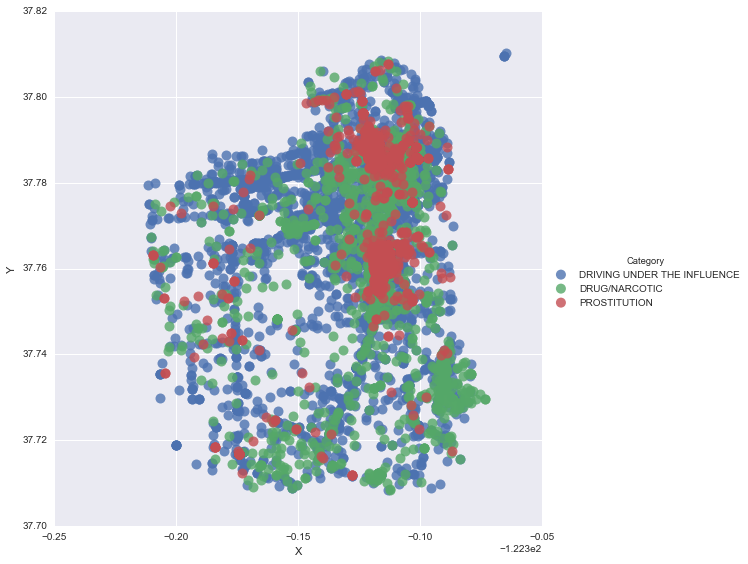

In [8]:
# Create a simple plot of the dataset before the classification
sns.lmplot('X', 'Y', data=helper_df, fit_reg=False,hue="Category", size=8,scatter_kws={"marker": "D","s": 100})

In [17]:
# Create a dictionary and put each crime's coordinates as a seperate key,value pair
geo_dict_b = {}
for crime in more_focusedcrimes:
    geo_data_for_plotting_b = {"lat": [float(el) for el in list(helper_df[helper_df['Category']==crime]['Y'])],
                             "lon": [float(el) for el in list(helper_df[helper_df['Category']==crime]['X'])]}
    geo_dict_b[crime] = geo_data_for_plotting_b
    
#Ready for plotting
for i,crime in enumerate(more_focusedcrimes):
    # Create a legend
    print '%s\t\t ----->\t\t%d observations\t\t ----->\t\t%s' % (colors[i],len(geo_dict_b[crime]['lon']),crime)
    # Fit the map with dots
    geoplotlib.dot(geo_dict_b[crime], color=colors[i], point_size=1)

# Create an BoundigBox for the limits of the map
bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                   west=min(geo_data_for_plotting['lon']),
                   south=min(geo_data_for_plotting['lat']),
                   east=max(geo_data_for_plotting['lon']))
geoplotlib.set_bbox(bbox)
geoplotlib.inline()


red		 ----->		3333 observations		 ----->		PROSTITUTION
green		 ----->		3333 observations		 ----->		DRUG/NARCOTIC
blue		 ----->		3333 observations		 ----->		DRIVING UNDER THE INFLUENCE


If you a take a close look at the position of the dots on the map it resebles the scatter plot from above. Now we can fit our model.

* *Visualize your model by coloring the grid, coloring each grid point according to it's category. Create a plot of this kind for models where each point is colored according to the majority of its 5, 10, and 30 nearest neighbors. Describe what happens to the map as you increase the number of neighbors, K.*

### Before classification

In [31]:
class CustomLayer(BaseLayer):

    def __init__(self, data):
        self.data = data

    def invalidate(self, proj):
        x, y = proj.lonlat_to_screen(self.data['X'], self.data['Y'])
        self.painter = BatchPainter()
        #self.painter.points(x, y)
        #self.cmap = create_set_cmap(set(data['Category']),'hsv' ) #'hsv'
        self.cmap = {'DRIVING UNDER THE INFLUENCE': [0, 15, 255, 255], 'PROSTITUTION': [255, 0, 0, 255], 'DRUG/NARCOTIC': [7, 255, 0, 255]}
        
        for crime in set(data['Category']):
            self.painter.set_color(self.cmap[crime]) #self.cmap[crime]
            self.painter.points(x[data['Category'] == crime], y[data['Category'] == crime], 3)
            self.painter.convexhull(x[data['Category'] == crime], y[data['Category'] == crime])
        

    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        self.painter.batch_draw()
        
data = helper_df
geoplotlib.add_layer(CustomLayer(data))
geoplotlib.set_smoothing(True)
bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                   west=min(geo_data_for_plotting['lon']),
                   south=min(geo_data_for_plotting['lat']),
                   east=max(geo_data_for_plotting['lon']))
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

### KNN with 5,10 and 30 nearest neighbors

In [158]:
class KNeighbors(BaseLayer):

    def __init__(self, data,k):
        self.data = data
        self.k = k # starting number of classifiers
        


    def invalidate(self, proj):
        self.painter = BatchPainter() # initilizes the painter
        features = np.array(helper_df[['X','Y']]) # saves features for the classifier
        labels = np.array(helper_df['Category']) # sasves labels for the classifier
        x, y = proj.lonlat_to_screen(self.data['X'], self.data['Y']) # creates 2 arrays of numbers corresponding to lon and lat
        print x[:10]
        
        # Train the KNN classifier
        clf = KNeighborsClassifier(n_neighbors=self.k)
        clf.fit(features, labels)
        pred = clf.predict(features) # creates an array of predicted crime categories

        # Create autogenerated colormap per crime
        #self.cmap = create_set_cmap(set(labels), 'hsv') # change 'hsv' with 'inferno' or 'hot'
        self.cmap = {'DRIVING UNDER THE INFLUENCE': [0, 15, 255, 255], 'PROSTITUTION': [255, 0, 0, 255], 'DRUG/NARCOTIC': [7, 255, 0, 255]}
        for crime in set(labels):
            self.painter.set_color(self.cmap[crime]) # picks 1 of 3 different colors randomly
            self.painter.points(x[pred == crime], y[pred == crime], 3) # paints the points according to predicted crimes

            #self.painter.convexhull(x[pred == crime], y[pred == crime]) # creates the polygons around the points
    
    # Map interaction. Increase/Decrease number of neighbors        
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        ui_manager.info('Number of neighbors : %d' % self.k)
        self.painter.batch_draw()

data = helper_df
k_numbers=[5,10,30]
for k in k_numbers:
    
    geoplotlib.add_layer(KNeighbors(data,k))
    geoplotlib.set_smoothing(True)
    bbox = BoundingBox(north=max(geo_data_for_plotting['lat']),
                           west=min(geo_data_for_plotting['lon']),
                           south=min(geo_data_for_plotting['lat']),
                           east=max(geo_data_for_plotting['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()
    #geoplotlib.show() # if you want to see the interaction with the neighbors
    #We have to fix the colors

1793239    167542
545174     167789
642752     167790
46749      167695
1775794    167749
638892     167731
1967885    167576
1896679    167572
235071     167712
598889     167600
Name: X, dtype: int64


1793239    167542
545174     167789
642752     167790
46749      167695
1775794    167749
638892     167731
1967885    167576
1896679    167572
235071     167712
598889     167600
Name: X, dtype: int64


1793239    167542
545174     167789
642752     167790
46749      167695
1775794    167749
638892     167731
1967885    167576
1896679    167572
235071     167712
598889     167600
Name: X, dtype: int64


## Part 2 Linear Regression

* *Just a few questions to check that you've read the material.*

>*What's the point of the error term ϵi? (That one wasn't around when you learned how to figure out the slope and y intercept of straight lines in high school).*

εi is a small error term representing the fact that there are other factors not accounted for by the simple model. It is usually refered as noise.

* *Why do you think Joel figures out how to find α and β using gradient descent when we already know how to find the best values analytically?*

Because he needed a better way to figure out how well he would have fit the data than plotting at a graph first. A common measure is the coefficient of determination (or R-squared), which measures the fraction of the total variation in the dependent variable that is captured by the model. He chose the alpha and beta that minimized the sum of the squared prediction errors.

## Part 4: Use regression models

* *We start by picking an area and a crime type, I'm starting with all of SF and LARCENY/THEFT just to have a lots of data, but you're free to try different crime types and areas. We will use 2015 data for training (or feel free grab everything if need big data in your life).*

In [47]:
# Check number of occurences of a specific crime per district
df[df['Category']=='LARCENY/THEFT'].groupby(df['PdDistrict'])['PdDistrict'].count()

PdDistrict
BAYVIEW        24262
CENTRAL        61828
INGLESIDE      23339
MISSION        42020
NORTHERN       70431
PARK           22601
RICHMOND       25047
SOUTHERN      101246
TARAVAL        28498
TENDERLOIN     22897
Name: PdDistrict, dtype: int64

So from the above projection we decided that we will focus on **LARCENY/THEFT** category in **SOUTHERN** district which includes plenty of observations and we will try to fit all this as training data into the following classifier.

In [52]:
# Let's create a filtered in out needs dataframe
df_superfocused = df[(df['Category']=='LARCENY/THEFT')& (df['PdDistrict']=='SOUTHERN')]

>*From last week we know that there is a strong connection between time-of-day and the number of crimes.*

>*We need variables that have an approximately linear dependence on each other, but the daily crime counts are non-monotonic: they go up and then down again. For that reason, we will only make predictions for the interval 5am-5pm where the crime count for LARCENY/THEFT is more or less linearly increasing.*

In [55]:
# We only need time
df_linear = df_superfocused.filter(items=['Time']) 

# Create a function that returns the time
def getHour(s):
    return int(s.split(':')[0])

# Now create a new column named hour and store the values of the above function
df_linear['Hour']= df_linear['Time'].apply(lambda x: getHour(x))

# List the number of crimes per year
df_linear = df_linear.groupby('Hour')['Hour'].count().reset_index(name='count').sort_values(by='Hour', ascending=True)

# Keep only from 5am to 5pm
df_linear = df_linear[(df_linear['Hour']>4)&(df_linear['Hour']<18)]

df_linear

Hour  count
5      5    576
6      6    962
7      7   1443
8      8   2543
9      9   3225
10    10   4024
11    11   4603
12    12   5794
13    13   5570
14    14   5609
15    15   5726
16    16   6041
17    17   7142

* *Let's check that there actually is a correlation. The goal is to first create a scatterplot.*
>* Put time-of-day (in the range 05:00-17:00) on the xx-axis.
>* Next you go over the training data and bin and observed number of LARCENY/THEFT crimes per hour. You should have 12 data-points per day of training data.
>* Plot the (time-of-day, bin-count) tuples. Does it look like there is a correlation?
>* Report the Pearson-correlation.
>* Now we can fit a straight line to the data, add the straight line to your scatterplot (similar to fig 14-1 in the book).

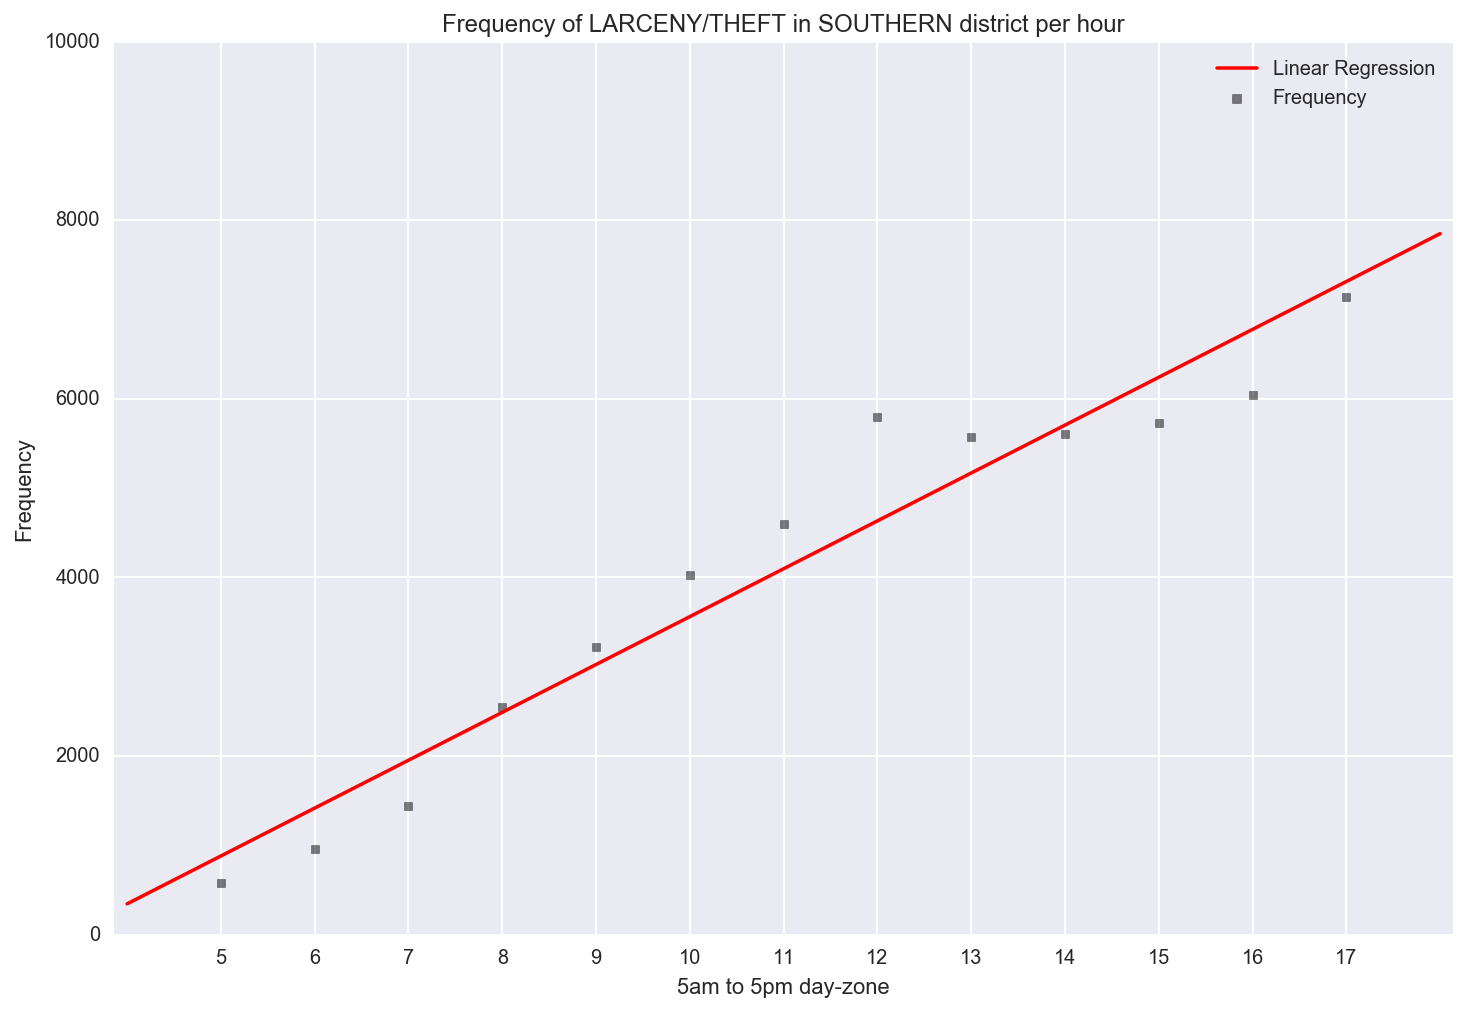

Pearson Correlation  	-->	0.9687699286


In [97]:
%config InlineBackend.figure_format = 'retina'

# Assign x and y values
x = df_linear['Hour']
y = df_linear['count']

# Create slope and intercept to create the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# Assign x_lin and y_lin values
x_lin = np.linspace(min(x)-1,max(x)+1)
y_lin = slope*x_lin+intercept #linear fit

# Assign the size of the plot before declaring the plot
plt.figure(figsize= (12,8))

# Give the x and y values to the scatterplot and the regression line
plt.scatter(x, y, color='black',marker='s', alpha=.5,label='Frequency')

# Give labels and titles
plt.ylabel("Frequency")
plt.title("Frequency of LARCENY/THEFT in SOUTHERN district per hour")
plt.xticks(range(5,18,1))
plt.xlabel("5am to 5pm day-zone")

#Set margins
plt.margins(0.01,0)
plt.ylim(0,10000)

plt.plot(x_lin,y_lin,'r-',label='Linear Regression')
plt.legend()

# Show the barplot
plt.show()

print 'Pearson Correlation  \t-->\t%.10f' % pearsonr(x,y)[0]

As we can see from the plot and the Pearson correlation value, the x and y axis are highly correlated.

>*Creating the line above required a lot of data-wrangling, but we've basically just fit a straight line ... something we've known how to do for many years (and not thought about it as a prediction tool). Now, we're going to go a little bit futher.*

>*We are going to improve/extend our model by incorporating the **total amount of crime** in the area we're considering (e.g. all of SF).*

>*The idea is that if there is a lot going on a certain day (e.g. a protest or a music festival taking place), then more crime in general will be happening - including more of the crime we're looking at (e.g. LARCENY/THEFT).*

>*Before we can include this in the model, however, we have to think carefully. There are two important points*

## Point 1: Difference wrt average.

>*Remember that we should not have correlations between our the variables in multiple regression (see chapter 15, "Further Assumptions of the Least Squares Model"). But we expect the **total amount of crime** variable to be strongly correlated with **time-of-day** variable.*

>*We can remove this dependence, however, by looking at a slightly tweaked version of the total amount of crime variable. Instead of simply considering the total number of crimes, we will work with the **difference in total amount of crime with respect to the average total number of crimes in that time-bin**. Let's consider how to calculate this quantity **for a specific timebin**. Let's pick 5am-6am; we simply call this bin 5am to keep the notation nice and clean.*

>*We start by calculating the average number of crimes in that bin. Thus, for each day in the training period (e.g. 2015), you measure the total number of crimes in the city between 5am and 6am. That gives you a list of 365365 values, one for each day in the period. Let's call this list $C(5am)=[C_\textrm{jan1}(5am),C_\textrm{jan2}(5am),…,C_\textrm{dec31}(5am)]$.*

>*You then add up the count for all days and divide by the number of days to find the average*

>*$$C^{ave}(5am)= \frac{1}{365}\sum\limits_{i\in \text\{days\ in\ 2015\}}C_\textrm{i}(5am)$$*

>*To get the difference with respect to the average, $C^{eff}(5am)$, for each day in the 5am-6am bin, you simply look at the element-wise difference to the actual counts $C(5am)$.*

>\begin{eqnarray*}
C^{eff}(5am) &=& C(5am)-C^{ave}(5am) \\ 
&=&\left[C_{jan 1}(5am)-C^{ave}(5am),C_{jan 2}(5am)-C^{ave}(5am),\ldots,C_{dec 31}(5am)-C^{ave}(5am)\right]\\ &=&\left[C^{eff}_{jan 1}(5am), \ldots, C^{eff}_{dec 31}(5am)\right]
\end{eqnarray*}

>**Examples**. So, to pick a concrete example: if the average number of crimes in the $5am$ bin is $C^{ave}(5am) = 5.4$ and we observe $C_{jan 1}(5am) = 8$ on January 1st, then we have, $C^{eff}_{jan 1}(5am) = C_{jan 1}(5 am) - C^{ave}(5am) = 2.6$ as our observation for that time-bin. This encodes that 8 crimes is $2.6$ more that we would expect, on average, in the $5am$ timebin. Similarly, if we had observed $4$ crimes for that bin, we would use $C^{eff}_{jan 1}(5am) = -1.4$ as our observation. This encodes that we are observing less crime that we expect based on what happens on average.

>*Finally, we perform the same calculation for all of the time-bins between 5am-5pm to get the full set of observations for the total crime counts variable.*

In order to do the above, we will use the main dataframe. Firstly we will get year from the date column and for the time variable(hours) we will do the same as on the previous exercise.

In [101]:
def getYear(date):
    return int(date.split('/')[2])

# Create a function that returns the time
def getHour(s):
    return int(s.split(':')[0])

#Adding new column in the dataframe
df['Year'] = df['Date'].apply(lambda x: getYear(x))

#Adding a new column named hour and store the values of the getHour function
df['Hour']= df['Time'].apply(lambda x: getHour(x))

We will pick 2016 as a training dataset this time, as it is simpler to calculate the average number of crimes per hour for one specific year. As 2016 was a leap year, we will divide number of crimes per day with 366

In [181]:
# Define training data
df_2016 = df[(df['Year']==2016)&(df['Hour']>4)&(df['Hour']<18)]

# List the number of crimes per hour
df_2016_counter = df_2016.groupby('Hour')['Hour'].count().reset_index(name='total_count').sort_values(by='Hour', ascending=True)

# Create a column with the average number of crimes per day
df_2016_counter['avg_count'] = df_2016_counter['total_count']/366

df_2016_counter

Hour  total_count  avg_count
0      5         1736   4.743169
1      6         2505   6.844262
2      7         3879  10.598361
3      8         5523  15.090164
4      9         5814  15.885246
5     10         6445  17.609290
6     11         6751  18.445355
7     12         8867  24.226776
8     13         7245  19.795082
9     14         7586  20.726776
10    15         8292  22.655738
11    16         8618  23.546448
12    17         9527  26.030055

In [182]:
# List the number of crimes per day of 2016
df_2016_day_counter = df_2016.filter(items=['Date', 'Hour']).groupby(['Date','Hour'])['Date'].count().reset_index(name='day_count').sort_values(by=['Date', 'Hour'], ascending=True)
df_2016_day_counter.head()

Date  Hour  day_count
0  01/01/2016     5          8
1  01/01/2016     6          6
2  01/01/2016     7          9
3  01/01/2016     8         10
4  01/01/2016     9         10

Now that we have all the information we want, we will merge the above dataframes with the Hour as a key.

In [183]:
# Merge tables and sort them in the same way
df_2016_merge = pd.merge(df_2016_day_counter,
                              df_2016_counter.filter(items=['Hour','avg_count']),
                              on='Hour').sort_values(by=['Date', 'Hour'], ascending=True)

df_2016_merge.head()

Date  Hour  day_count  avg_count
0     01/01/2016     5          8   4.743169
360   01/01/2016     6          6   6.844262
723   01/01/2016     7          9  10.598361
1087  01/01/2016     8         10  15.090164
1453  01/01/2016     9         10  15.885246

In [184]:
# Create the difference column
df_2016_merge['diff_count']=df_2016_merge['day_count']-df_2016_merge['avg_count']
df_2016_merge.head()

Date  Hour  day_count  avg_count  diff_count
0     01/01/2016     5          8   4.743169    3.256831
360   01/01/2016     6          6   6.844262   -0.844262
723   01/01/2016     7          9  10.598361   -1.598361
1087  01/01/2016     8         10  15.090164   -5.090164
1453  01/01/2016     9         10  15.885246   -5.885246

## Point 2: Rescaling

>*In order for the multiple regression to work well, it is important that the input variables have approximately the same size, so I recommend you rescale both of your input variables to e.g. the range [0,1].*

In [ ]:
# Rescale the data features to range[0,1](Normalization)
normalized_X = preprocessing.normalize(X)

## Back to the exercise

>**Connection to linear regression**. *So adding an additional input variable still has a clear interpretation. What you'll be doing is basically plotting a 3D point-cloud. The regression fits a neat plane to your data-cloud. And when we want to make a prediction, we find the time-of-day we want to predict for as well as the effective number of crimes, and based on those two numbers we can read the value off the fitted plane.*

>With all that preparation, we're ready for the exercise.

>* *Start by preparing your data as described above.*
>* *Fit the data using multiple regression.*

0.867867207449


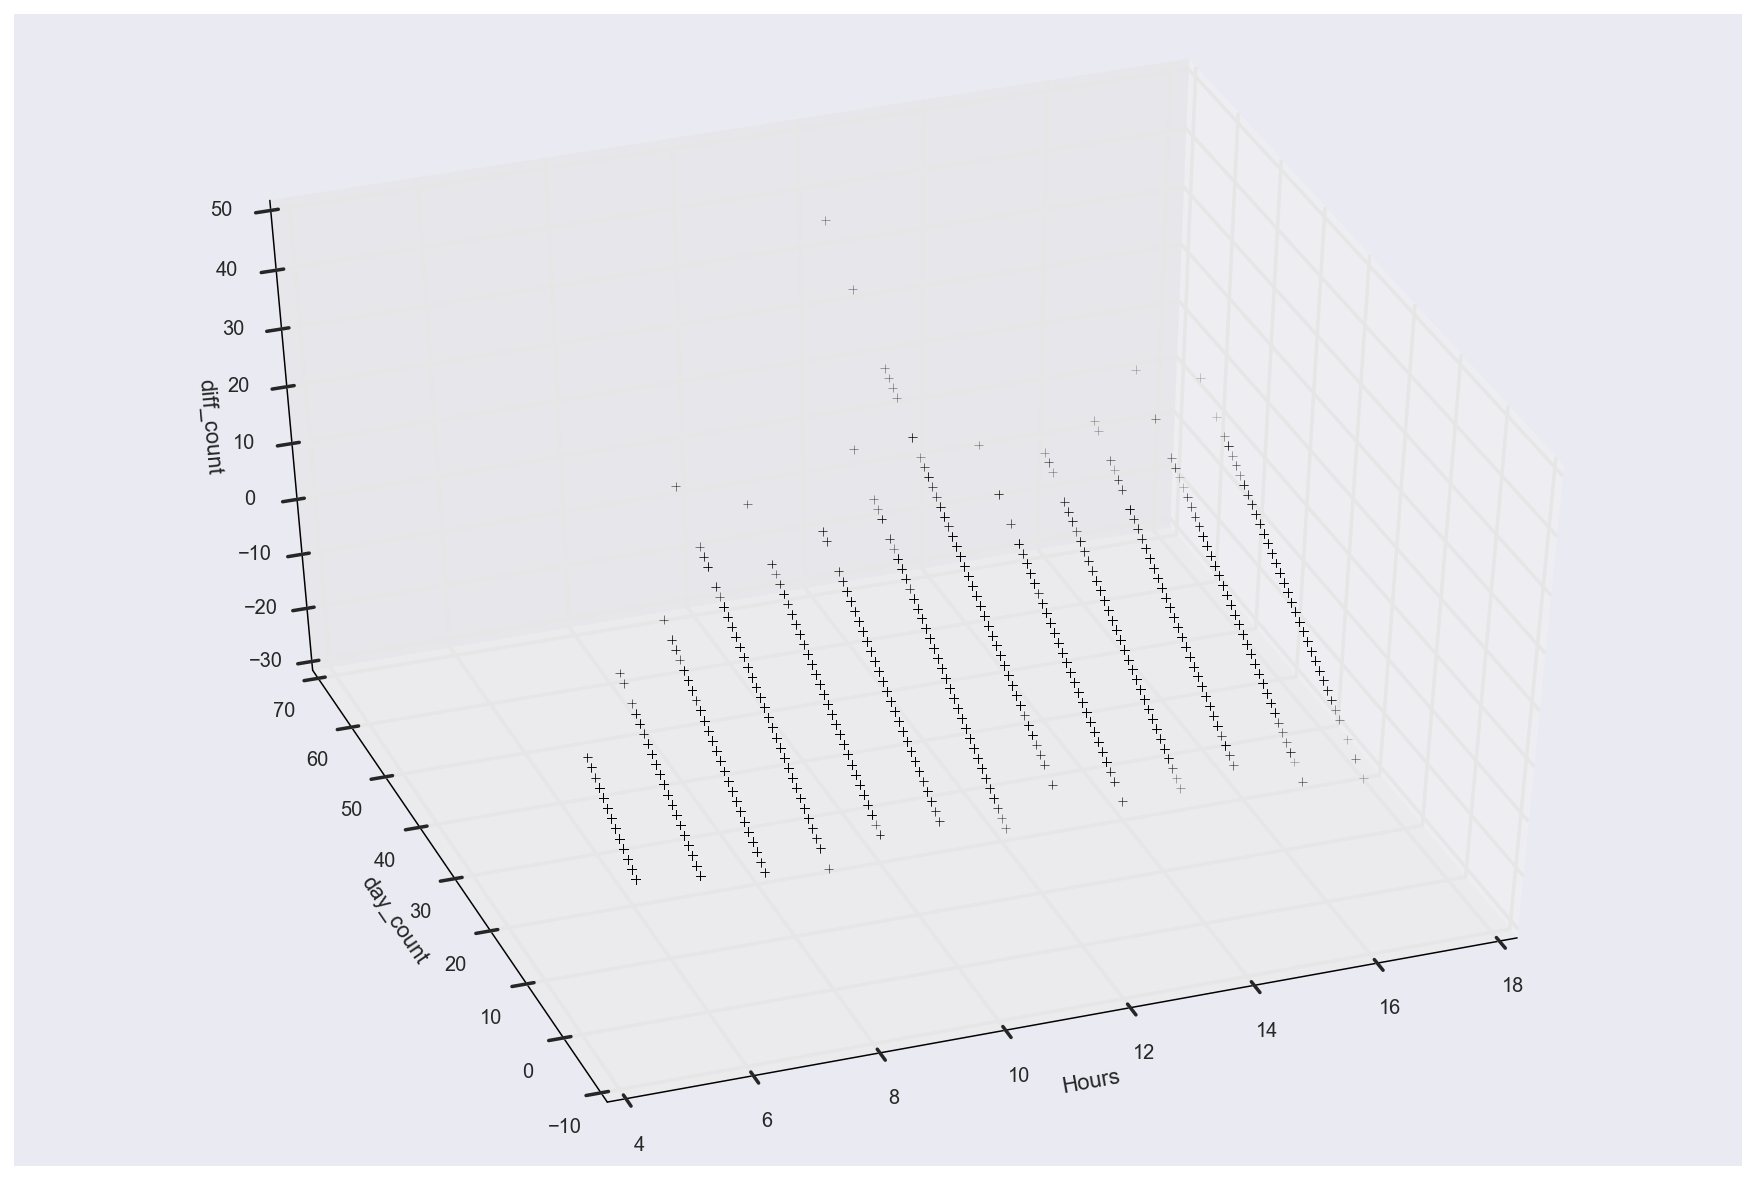

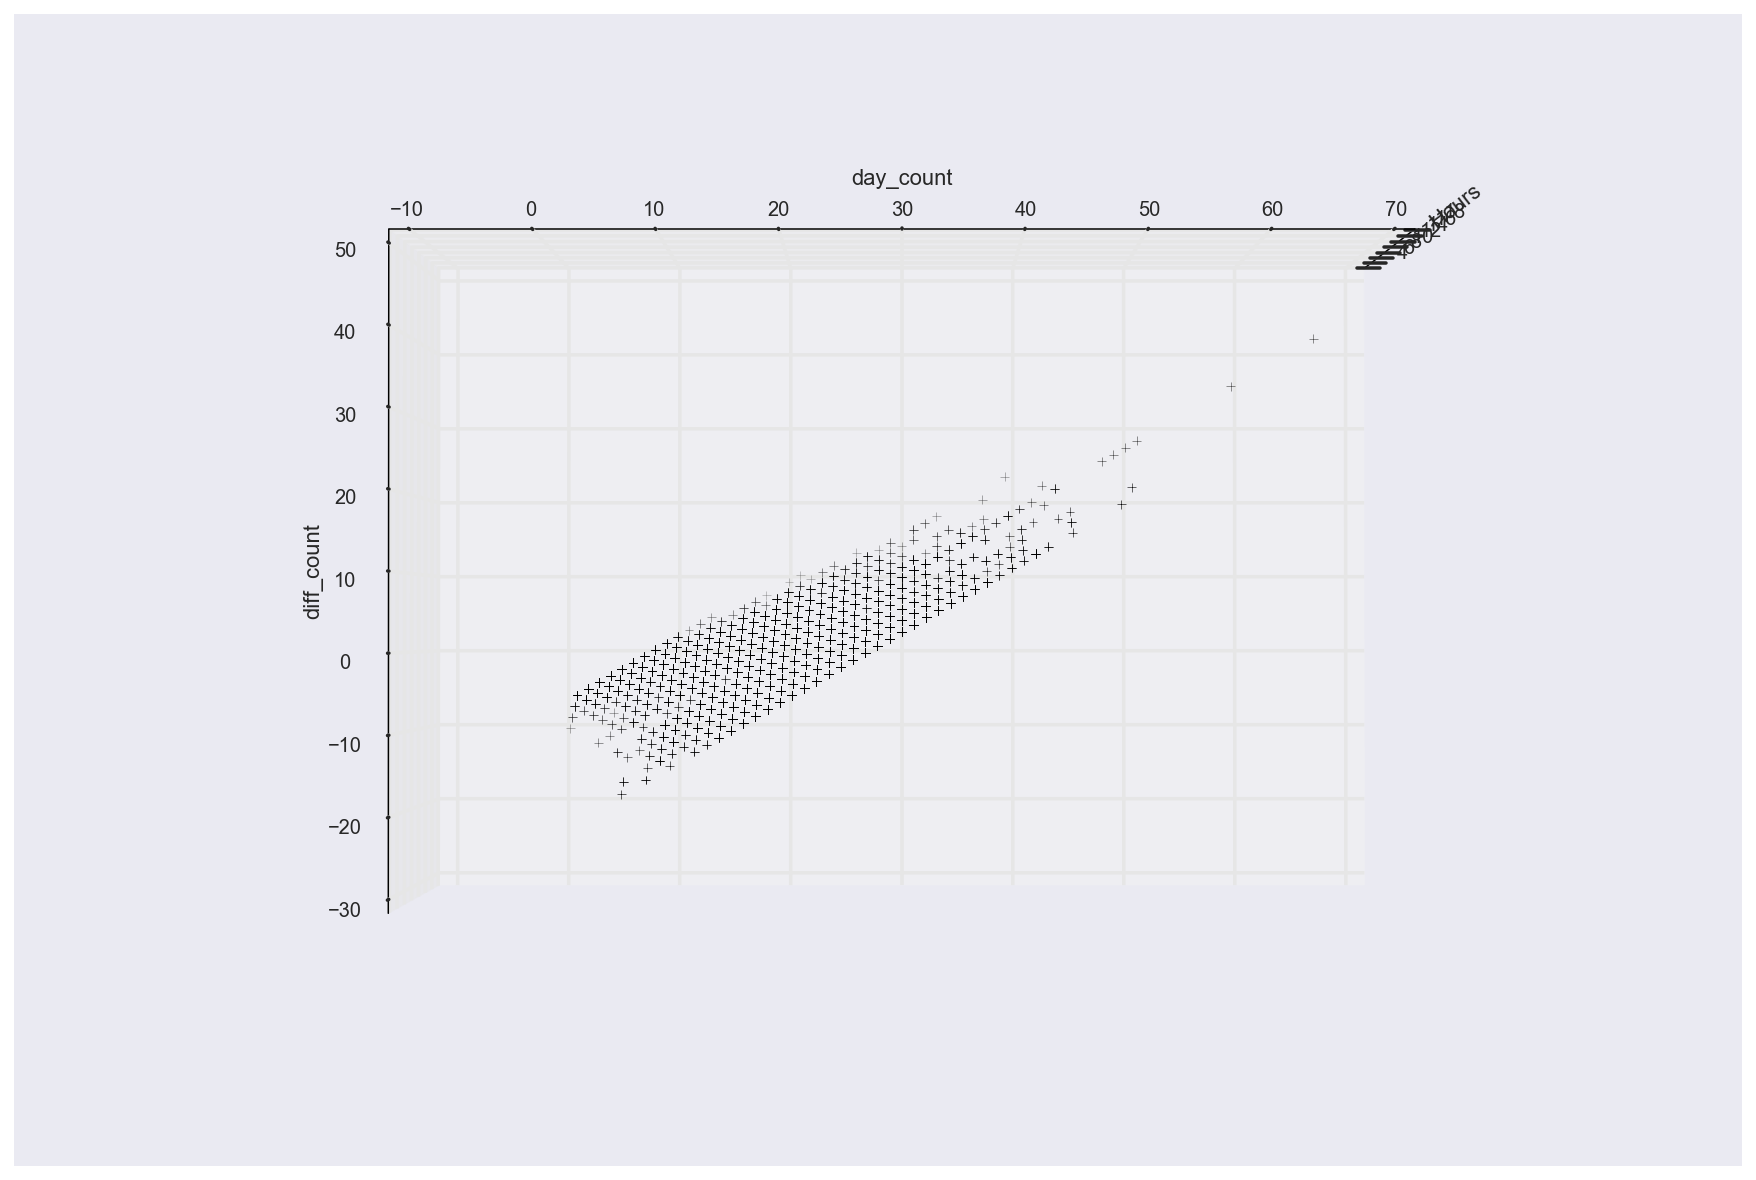

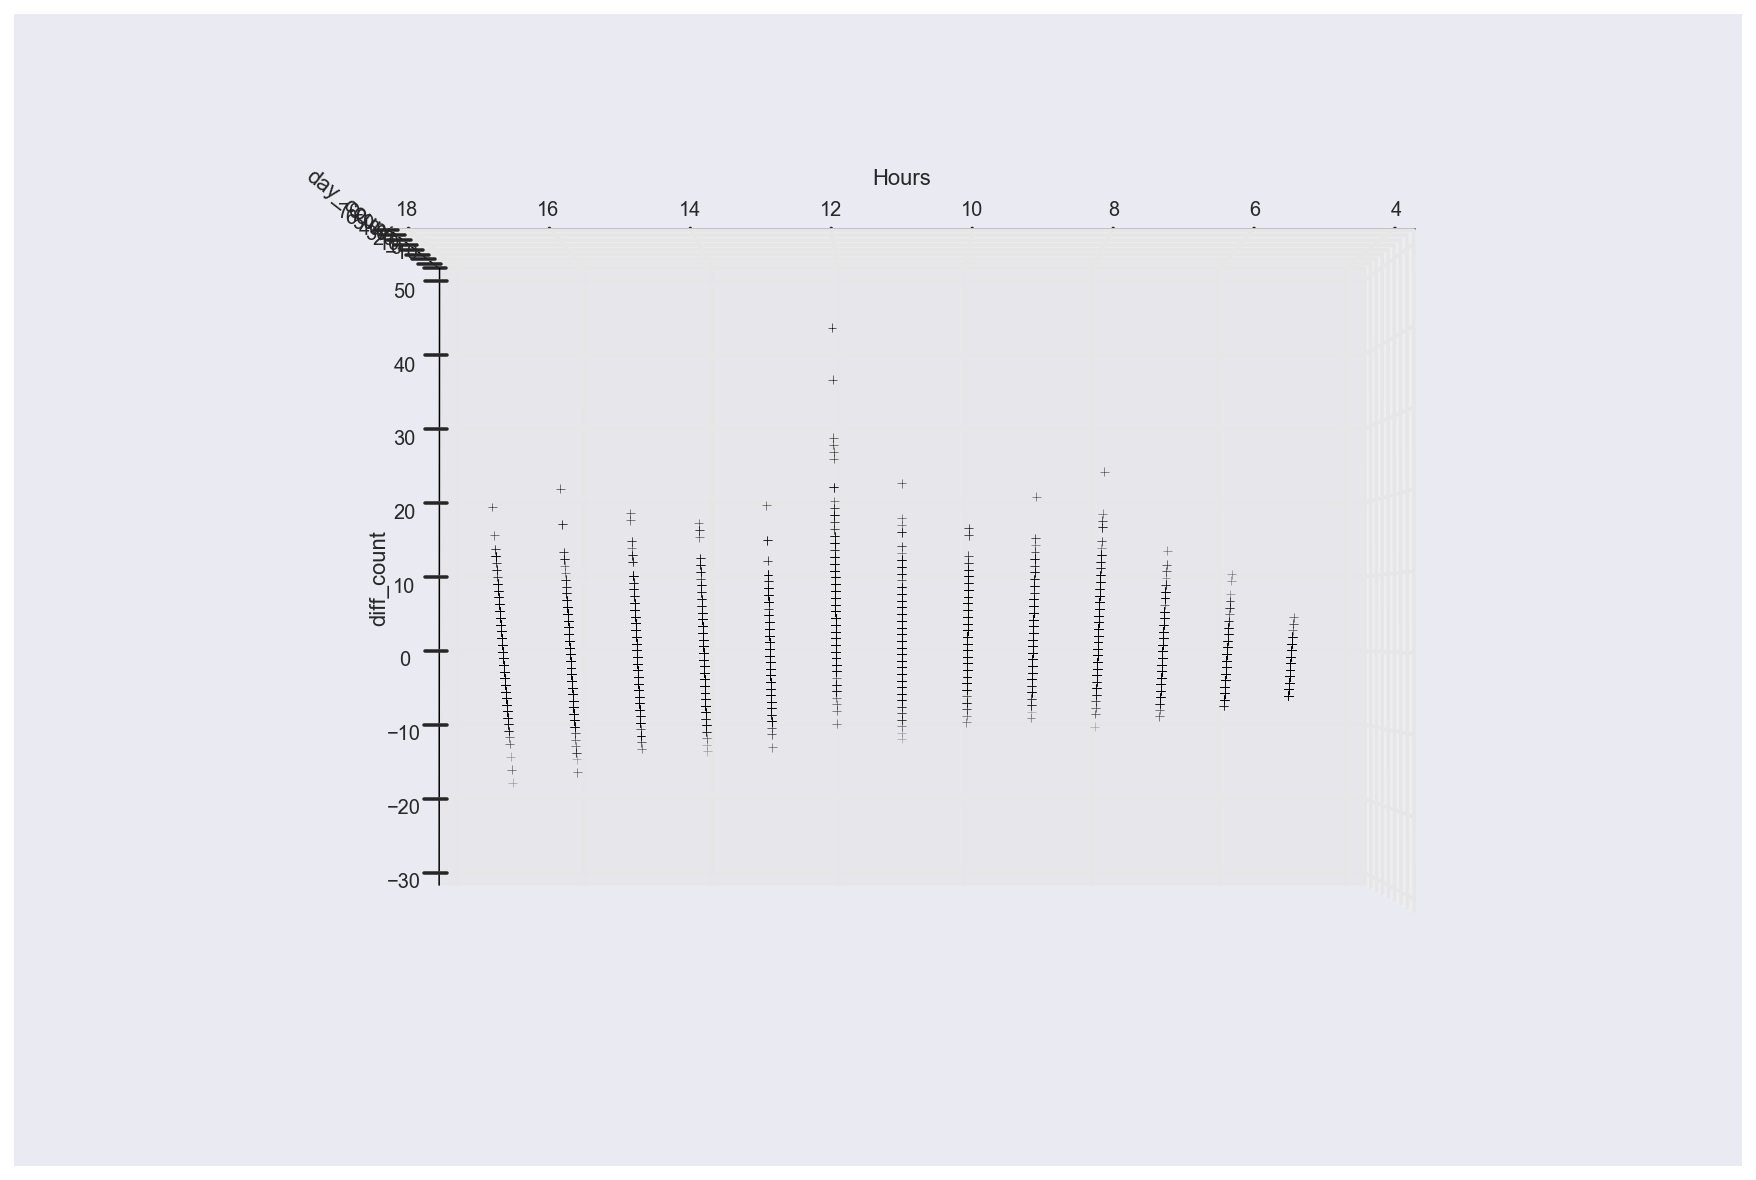

In [211]:
# Assign x and y values
features = np.array(df_2016_merge[['Hour','day_count']])
labels = np.array(df_2016_merge['diff_count'])


# Fit the linear Regression model
mlr = linear_model.LinearRegression(normalize=True)
mlr.fit(features, labels)
pred = mlr.predict(features)
print mlr.score(features,labels)

# Plot the 3D figure
def plot_figs(fig_num, elev, azim, features, clf):
    fig = plt.figure(fig_num, figsize=(12, 8))
    plt.clf()
    ax = Axes3D(fig, elev=elev, azim=azim)

    ax.scatter(features[:, 0], features[:, 1], clf.predict(features), c='k', marker='+')
    
    ax.set_xlabel('Hours')
    ax.set_ylabel('day_count')
    ax.set_zlabel('diff_count')
    #ax.w_xaxis.set_ticklabels(range(5,18,1))
    #ax.w_yaxis.set_ticklabels([])
    #ax.w_zaxis.set_ticklabels([])

#Generate the three different figures from different views
elev = 43.5
azim = -110
plot_figs(1, elev, azim, features, mlr)

elev = -.5
azim = 0
plot_figs(2, elev, azim, features, mlr)

elev = -.5
azim = 90
plot_figs(3, elev, azim, features, mlr)

plt.show()

In [207]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets, linear_model

diabetes = datasets.load_diabetes()
indices = (0, 1)

X_train = diabetes.data[:-20, indices]
X_test = diabetes.data[-20:, indices]
y_train = diabetes.target[:-20]
y_test = diabetes.target[-20:]
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

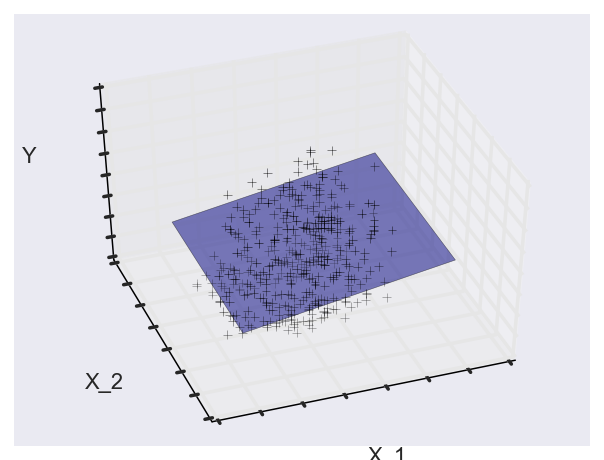

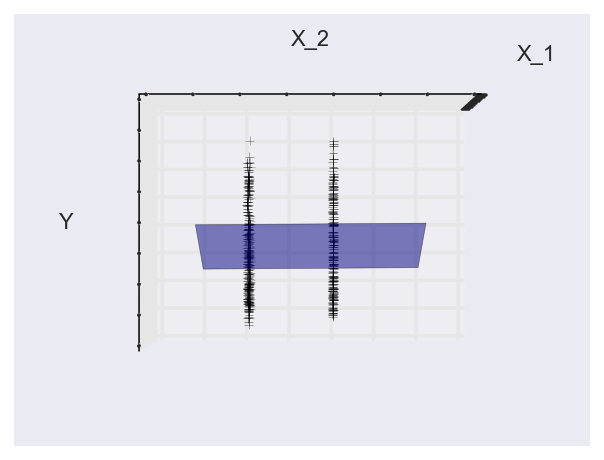

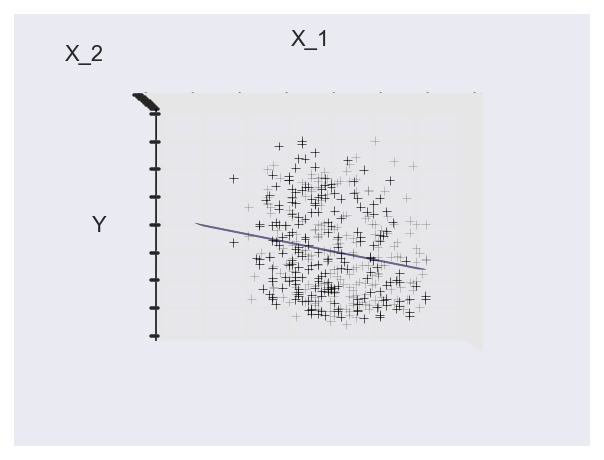

In [197]:
def plot_figs(fig_num, elev, azim, X_train, clf):
    fig = plt.figure(fig_num, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, elev=elev, azim=azim)

    ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c='k', marker='+')
    ax.plot_surface(np.array([[-.1, -.1], [.15, .15]]),
                    np.array([[-.1, .15], [-.1, .15]]),
                    clf.predict(np.array([[-.1, -.1, .15, .15],
                                          [-.1, .15, -.1, .15]]).T
                                ).reshape((2, 2)),
                    alpha=.5)
    ax.set_xlabel('X_1')
    ax.set_ylabel('X_2')
    ax.set_zlabel('Y')
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

#Generate the three different figures from different views
elev = 43.5
azim = -110
plot_figs(1, elev, azim, X_train, ols)

elev = -.5
azim = 0
plot_figs(2, elev, azim, X_train, ols)

elev = -.5
azim = 90
plot_figs(3, elev, azim, X_train, ols)

plt.show()